# Import stuff

In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import scikitplot as skplt

from xgboost import XGBClassifier
from xgboost import plot_importance

import shap
shap.initjs()

In [5]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


# Load data, clean, feature engineering...

In [6]:
df = pd.read_csv('../data/titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
df['Embarked'].fillna('S', inplace = True)
df_embarked = pd.get_dummies(df['Embarked'], prefix='Embarked', drop_first = True)
df = pd.concat([df, df_embarked], axis=1).drop(['Embarked'], axis=1)
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Split & train

In [8]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

In [9]:
xgb = XGBClassifier(max_depth=5, n_estimators = 100, learning_rate=0.1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

# Evaluate

In [10]:
accuracy = accuracy_score(y_valid, xgb.predict(X_valid))
print("Model accuracy is:  {}".format(accuracy))

Model accuracy is:  0.8212290502793296


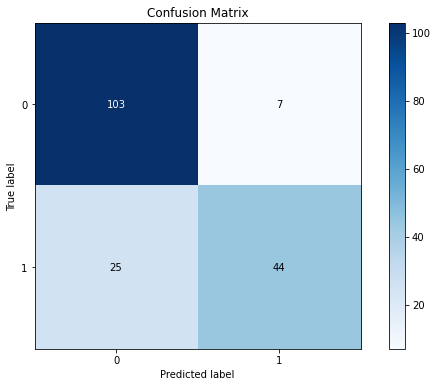

In [11]:
skplt.metrics.plot_confusion_matrix(y_valid, xgb.predict(X_valid))
plt.show()

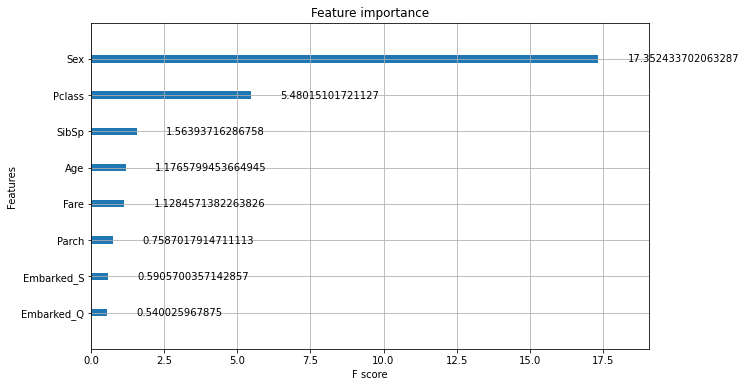

In [12]:
plot_importance(xgb, importance_type="gain")
plt.show()

# Sample predict

In [13]:
X_valid.iloc[[112]]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
796,1,1,49.0,0,0,25.9292,0,1


In [14]:
xgb.predict(X_valid.iloc[[112]])

array([1], dtype=int64)

actual result:

In [15]:
y_valid.iloc[112]

1

# ok bye

<br><br>
<br><br>
<br><br>
<br><br>
<br><br>
<br><br>
<br><br>
<br><br>
<br><br>

...or not

![](img/explain.jpg)

# Explain (a prediction) to me!

Create an explainer

In [16]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

Explain a prediction

(112 & 44 for example)

In [22]:
shap.force_plot(explainer.expected_value, explainer.shap_values(X_valid.iloc[112]), X_valid.iloc[112])

#### Alternative to force plot

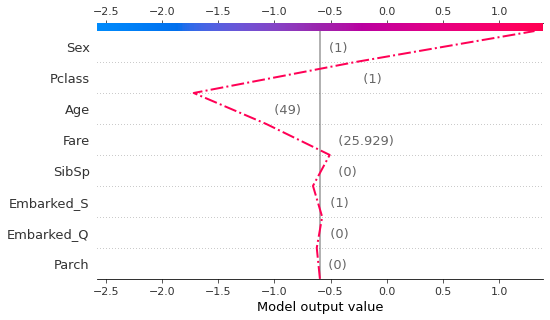

In [19]:
shap.decision_plot(explainer.expected_value, explainer.shap_values(X_valid.iloc[112]), X_valid.iloc[112], highlight=0)

### Wait, what is that value?

That value is the raw score from the model (in case of xgboost, the raw log odds score), before the logistic function (to classify). 

#### The weird (log odds) score:

In [20]:
import math
def sigmoid(x):
    return 1/(1+math.exp(-x))

So the starting probability is:

In [21]:
sigmoid(-0.5953)

0.35541971435073527

And the final probability after variables:

In [23]:
sigmoid(1.32)

0.789181706522253

#### The prediction probabilities:

In [24]:
xgb.predict_proba(X_valid.iloc[[112]])

array([[0.21164846, 0.78835154]], dtype=float32)

#### In the end...
By the way, the actual value or Survived for that obvs is:

In [25]:
y_valid.iloc[112]

1

Women and children first!


## You could use this in your predictions:

In [26]:
def get_relative_importance(explainer, names, obv):
    """
    Calculates the relative importance to the overall prediction. This is not translated into probability impact,
    but gives a better idea of the magnitude of a variable in the context of the others.
    
    The provided _explainer_ is applied to the provided observation (in _values_). Then the absolute shap values are 
    sumed and a percent is calculated from that total by feature (without the base value!)
    
    A dataframe is returned with the results
    
    Params:
       * explainer: SHAP explainer
       * names: column names of the features
       * values: column values of the observation
    """
    shap_values_obvs = explainer.shap_values(obv)
    interpretation = pd.DataFrame({"name":names,"value":shap_values_obvs[0]})
    interpretation['impact_from_base'] = interpretation['value'].abs()
    interpretation['impact_from_base'] = (interpretation['impact_from_base'] / interpretation['impact_from_base'].sum())
    return interpretation.sort_values(by=['impact_from_base'], ascending=False)

def predict_value(model, explainer, names, values):
    prediction = model.predict(values)[0]
    prob_score = model.predict_proba(values)[0][1]
    explanation = get_relative_importance(explainer, names, values)
    return {'prediction':prediction, 'prob_score':prob_score, 'explanation':explanation.to_dict(orient='records')}

In [27]:
get_relative_importance(explainer, X_valid.columns, X_valid.iloc[[112]])

,name,value,impact_from_base
1,Sex,1.593953,0.350253
0,Pclass,1.439683,0.316353
2,Age,-0.645447,0.141829
5,Fare,-0.564980,0.124148
3,SibSp,0.148845,0.032707
7,Embarked_S,-0.081944,0.018006
6,Embarked_Q,0.048109,0.010571
4,Parch,-0.027907,0.006132


### You could also return (or log) this:

In [29]:
predict_value(xgb, explainer,X_valid.columns, X_valid.iloc[[112]])

{'prediction': 1,
 'prob_score': 0.78835154,
 'explanation': [{'name': 'Sex',
   'value': 1.593953013420105,
   'impact_from_base': 0.35025250911712646},
  {'name': 'Pclass',
   'value': 1.4396830797195435,
   'impact_from_base': 0.3163534998893738},
  {'name': 'Age',
   'value': -0.6454469561576843,
   'impact_from_base': 0.14182941615581512},
  {'name': 'Fare',
   'value': -0.5649800300598145,
   'impact_from_base': 0.12414775043725967},
  {'name': 'SibSp',
   'value': 0.14884451031684875,
   'impact_from_base': 0.032706838101148605},
  {'name': 'Embarked_S',
   'value': -0.08194441348314285,
   'impact_from_base': 0.018006326630711555},
  {'name': 'Embarked_Q',
   'value': 0.048108942806720734,
   'impact_from_base': 0.010571377351880074},
  {'name': 'Parch',
   'value': -0.02790718525648117,
   'impact_from_base': 0.0061322771944105625}]}


<br><br>
<br><br>
<br><br>
<br><br>
<br><br>
<br><br>
<br><br>
<br><br>
<br><br>

![](img/but_wait.jpg)


# Explain (the model) to me!

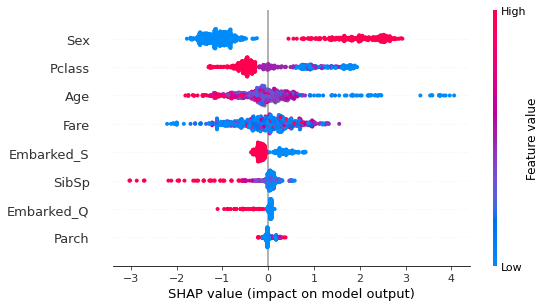

In [30]:
shap.summary_plot(shap_values, X_train, show = False)

* The gender has the maximum impact.
* Being on first, second or thirth class is key. First class people have a wide range of positive impact, second class gives (sans some exceptions) no advantage, while 3th is just plain negative
* Age has an interesting effect: Being very young has a great (in some cases, impressive) positive impact,people in their mid 30 are mixed, and older people ... had troubles.
* A high SibSp number can be very significant ... in a very bad way. Seems that in a big family, people had to choose :/
* Fare is quite the mixed bag

# Explain (the dataset) to me!

![](img/shap_graph.png)

In [31]:
shap.force_plot(explainer.expected_value, shap_values, X_train)

Interestingly you can find groups here.

1. The really, really unlucky children group
2. The """""lucky""""" baby group
3. A big group of first-class women with good (survived) prediction score.
4. A Second group of second-class women with good (survived) prediction score.
5. A second group of tirth-class women with an average (survived) prediction score.
6. The big group of unlucky tirth-class men...
7. A small group of more lucky first-class men...

# Explain (a variable) to me!

In [32]:
shap_interaction_values = explainer.shap_interaction_values(X_train)

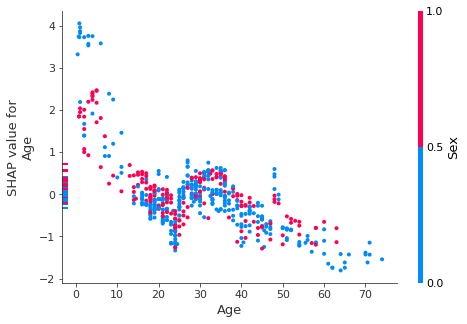

In [33]:
shap.dependence_plot("Age", shap_values, X_train, show = False)

1. A significant positive impact can be seen for Age < 10.
2. After 12 ¿? you are no longer a "children" ...
3. Impact improves a bit around 29 and 49

# Explain (two variables together) to me!

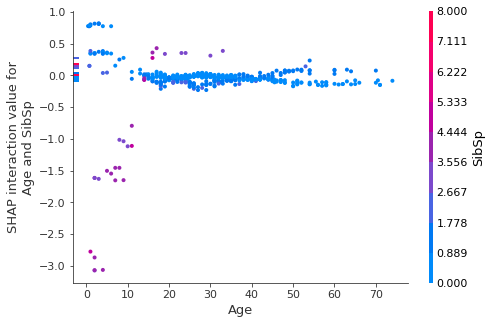

In [34]:
shap_interaction_values = explainer.shap_interaction_values(X_train)
shap.dependence_plot(("Age", "SibSp"),shap_interaction_values, X_train,display_features=X_train)

The bigger the family, the worse are your chances... if you are young, that is.